In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats

from utils import *

In [2]:
site = SITES['Fort Ross']

ghi_2015 = get_nsrdb_data(2015, 'ghi', site['nsrdb_site_id'], site['tz'])
ghi_2016 = get_nsrdb_data(2016, 'ghi', site['nsrdb_site_id'], site['tz'])
ghi_extended = pd.concat([ghi_2015, ghi_2016])

Found cached/site-131123-data-2015.pkl, loading...
Found cached/site-131123-data-2016.pkl, loading...


In [3]:
hot_rocks_df = get_hot_rocks_data()
temp_series = hot_rocks_df[hot_rocks_df['elev'] == 'high']['temp']

In [4]:
tide_years_padded = [get_year_padded(2015)[0], get_year_padded(2016)[1]]
tide_series = get_noaa_tide_preds(site, tide_years_padded)
tide_high_res = interpolate_tide_preds(tide_series, ghi_extended.index)

In [5]:
# Resample to get the maximum temperature for each day
daily_max_temp = temp_series.resample('D').max()

# Find the times of these maximum temperatures
max_temp_times = temp_series[temp_series.isin(daily_max_temp)].groupby(pd.Grouper(freq='D')).idxmax()

# Calculate tide at the timestamps of those maximum temperatures via interpolation
tide_at_max_temps = interpolate_tide_preds(tide_series, max_temp_times)

<Axes: xlabel='dt'>

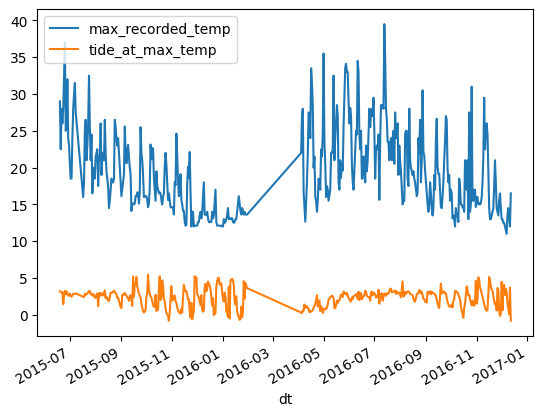

In [6]:
df = pd.DataFrame({"max_recorded_temp": daily_max_temp.values, "tide_at_max_temp": tide_at_max_temps.values}, index=daily_max_temp.index)
df = df.dropna()
df.plot()

In [7]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df['tide_at_max_temp'], df['max_recorded_temp'])

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")

Slope: -0.2548570019314413
Intercept: 19.853401754476014
R-squared: 0.0031295095365301423
P-value: 0.23213557632037074
Standard error: 0.2130077372512525


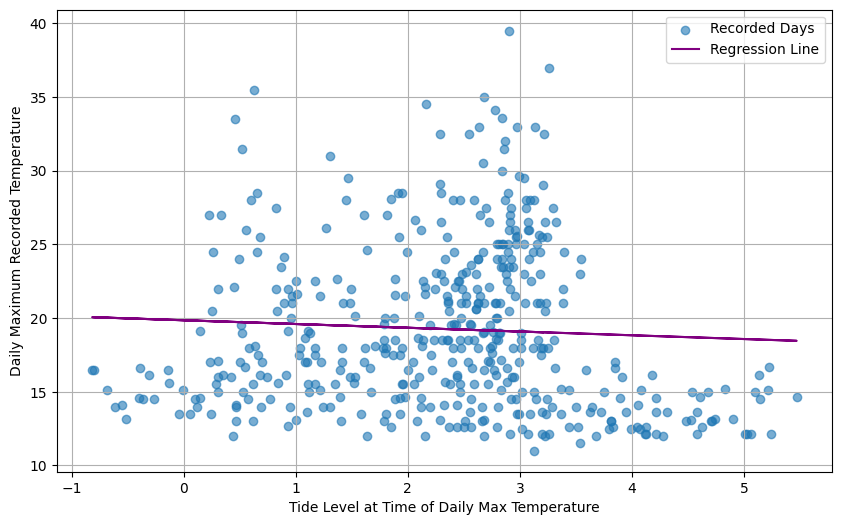

In [8]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['tide_at_max_temp'], df['max_recorded_temp'], alpha=0.6, label='Recorded Days')

# Calculate and add regression line
x = df['tide_at_max_temp']
y = intercept + slope * x
plt.plot(x, y, color='purple', label='Regression Line')

# Add plot title and labels
# plt.title('Analysis of Heat Exposure in the Intertidal Zone')
plt.xlabel('Tide Level at Time of Daily Max Temperature')
plt.ylabel('Daily Maximum Recorded Temperature (℃)')
plt.grid(True)
plt.legend()

# Display the plot
plt.show()


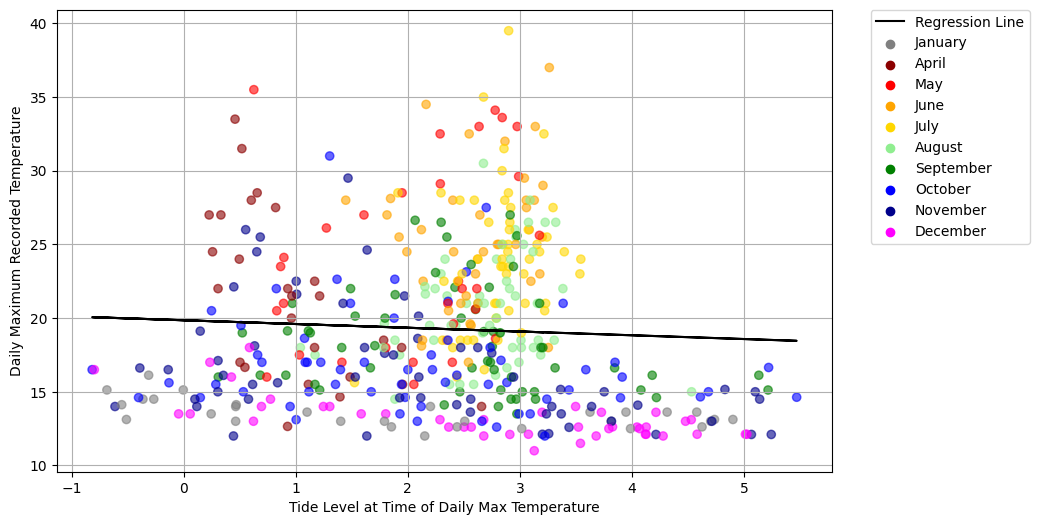

In [9]:

# Map the colors to the entries in the frame
colors = df.index.month.map(lambda x: MONTH_COLORS[x])

# Create a scatter plot with specific month colors
plt.figure(figsize=(10, 6))
sc = plt.scatter(df['tide_at_max_temp'], df['max_recorded_temp'], color=colors, alpha=0.6)

# Add regression line
x = df['tide_at_max_temp']
y = intercept + slope * x
plt.plot(x, y, color='black', label='Regression Line')  # Use a neutral color for the line

# Add invisible points for creating the legend for months
for month, color in MONTH_COLORS.items():
    plt.scatter([], [], color=color, label=pd.to_datetime(month, format='%m').month_name())

plt.xlabel('Tide Level at Time of Daily Max Temperature')
plt.ylabel('Daily Maximum Recorded Temperature (℃)')
plt.grid(True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()